In [1]:
# Libraries

import warnings

warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)


In [2]:
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

# visualizing pipelines in HTML
from sklearn import set_config

set_config(display='diagram')

pd.set_option('display.max_columns', None)

sns.set_style('darkgrid')

In [3]:
# Load data
df = pd.read_csv('../raw_data/listings.csv')

# No needed columns
# columns_todrop = [
#     'id', 'listing_url', 'scrape_id', 'name', 'description',
#     'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name',
#     'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url',
#     'host_verifications', 'neighbourhood', 'neighbourhood_group_cleansed',
#     'calendar_last_scraped', 'bathrooms', 'calendar_updated', 'license',
#     'host_response_time', 'host_response_rate', 'host_acceptance_rate',
#     'bathrooms_text', 'host_neighbourhood', 'last_review'
# ]
# df = df.drop(columns=columns_todrop)

# Converting Amenities from str to list
df['amenities'] = df['amenities'].apply(lambda x: ast.literal_eval(x))
df['total_amenities'] = df['amenities'].apply(lambda x: len(x))

# Droping null - subset: host since
df.dropna(subset=['host_since'], inplace=True)

# Formating to datetime
df[['host_since', 'first_review',
    'last_scraped']] = df[['host_since', 'first_review',
                           'last_scraped']].apply(pd.to_datetime)

# Calculating Host Tenure
df['host_tenure'] = (df['last_scraped'] - df['host_since']).dt.days

# Formating Price
df['price'] = df['price'].apply(lambda x: x.replace('$', '').replace(',', '')
                                if isinstance(x, str) else x).astype(float)

# Reseting Index
df.reset_index(drop=True, inplace=True)

df = df[df['price'] > 0]

df.head(5)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,total_amenities,host_tenure
0,13913,https://www.airbnb.com/rooms/13913,20211207182339,2021-12-09,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,https://www.airbnb.com/users/show/54730,Alina,2009-11-16,"London, England, United Kingdom",I am a Multi-Media Visual Artist and Creative ...,within a few hours,100%,85%,f,https://a0.muscache.com/im/users/54730/profile...,https://a0.muscache.com/im/users/54730/profile...,LB of Islington,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,"Islington, Greater London, United Kingdom",Islington,NaN,51.56861,-0.11270,Private room in rental unit,Private room,2,NaN,1 shared bath,1.0,NaN,"[Hot water, Heating, Coffee maker, Building st...",65.0,1,29,1.0,1.0,29.0,29.0,1.0,29.0,NaN,t,26,56,86,361,2021-12-09,22,1,1,2010-08-18,2021-11-21,4.86,4.80,4.85,4.80,4.90,4.65,4.75,NaN,f,2,1,1,0,0.16,42,4406
1,15400,https://www.airbnb.com/rooms/15400,20211207182339,2021-12-09,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,It is Chelsea.,https://a0.muscache.com/pictures/428392/462d26...,60302,https://www.airbnb.com/users/show/60302,Philippa,2009-12-05,"Kensington, England, United Kingdom","English, grandmother, I have travelled quite ...",within a day,67%,50%,f,https://a0.muscache.com/im/users/60302/profile...,https://a0.muscache.com/im/users/60302/profile...,Chelsea,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"London, United Kingdom",Kensington and Chelsea,NaN,51.48780,-0.16813,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[Hot water, Heating, Coffee maker, TV with sta...",75.0,3,50,3.0,3.0,50.0,50.0,3.0,50.0,NaN,t,0,0,0,4,2021-12-09,89,0,0,2009-12-21,2020-03-16,4.79,4.84,4.88,4.87,4.82,4.93,4.73,NaN,f,1,1,0,0,0.61,24,4387
2,17402,https://www.airbnb.com/rooms/17402,20211207182339,2021-12-09,Superb 3-Bed/2 Bath & Wifi: Trendy W1,You'll have a wonderful stay in this superb mo...,"Location, location, location! You won't find b...",https://a0.muscache.com/pictures/39d5309d-fba7...,67564,https://www.airbnb.com/users/show/67564,Liz,2010-01-04,"Brighton and Hove, England, United Kingdom",We are Liz and Jack. We manage a number of ho...,within an hour,80%,70%,f,https://a0.muscache.com/im/users/67564/profile...,https://a0.muscache.com/im/users/67564/profile...,Fitzrovia,18.0,18.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"London, Fitzrovia, United Kingdom",Westminster,NaN,51.52195,-0.14094,Entire rental unit,Entire home/apt,6,NaN,2 baths,3.0,3.0,"[Hot water, Heating, Coffee maker, Iron, Drye

## Top Amenities in London

In [4]:
counts = dict()
for i in df['amenities']:
    for j in i:
        counts[j] = counts.get(j, 0) + 1

top_ame = pd.DataFrame([counts]).T.reset_index()
top_ame.columns = ['Amenity', 'total_count']
top_ame.sort_values(by='total_count', ascending=False, inplace=True)
top_10 = top_ame.head(10)
top_10

,Amenity,total_count
18,Wifi,63474
26,Essentials,60069
21,Kitchen,60066
1,Heating,59114
28,Smoke alarm,57248
20,Long term stays allowed,54736
35,Washer,54030
32,Hangers,50621
8,Iron,49072
13,Hair dryer,44090


In [5]:
def ame(x):
    d = {}
    for i in x:
        if i in list(top_10['Amenity']):
            d[i] = d.get(i, 0) + 1
    return d


amenity = df[['id', 'neighbourhood_cleansed', 'amenities']]

amenity['dict'] = amenity['amenities'].apply(lambda x: ame(x))
amenity['total_top10'] = amenity['dict'].apply(lambda x: len(x))

amenity_from_dict = pd.json_normalize(amenity['dict'])
amenity_from_dict.reset_index(drop=True, inplace=True)

amenity.drop(columns=['amenities', 'dict'], inplace=True)
amenity.reset_index(drop=True, inplace=True)

df_amenity = pd.concat([amenity, amenity_from_dict], axis=1)

df_amenity

,id,neighbourhood_cleansed,total_top10,Heating,Iron,Hair dryer,Wifi,Long term stays allowed,Kitchen,Essentials,Smoke alarm,Hangers,Washer
0,13913,Islington,10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,15400,Kensington and Chelsea,9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0
2,17402,Westminster,10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,17506,Hammersmith and Fulham,7,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,NaN
4,25123,Barnet,10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66556,53709893,Croydon,8,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0
66557,53710986,Ealing,10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
66558,53711668,Haringey,9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0
66559,53712786,Kensington and Chelsea,10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


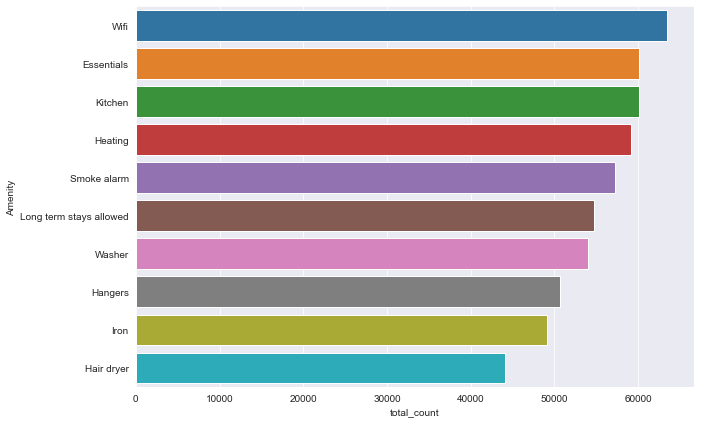

In [6]:
plt.figure(figsize=(10, 7))
sns.barplot(data=top_10, y='Amenity', x='total_count')
plt.show()

## Other Stats

In [7]:
numeric_col = [
    'id','neighbourhood_cleansed', 'accommodates', 'bedrooms', 'beds', 'price',
    'minimum_nights', 'availability_365', 'number_of_reviews',
    'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'total_amenities', 'host_tenure',
    'instant_bookable', 'room_type', 'host_listings_count',
    'host_is_superhost', 'host_acceptance_rate', 'host_response_rate'
]

data = df[numeric_col]

imputer_bedroom = KNNImputer(missing_values=np.nan)
imputer_bed = KNNImputer(missing_values=np.nan)

data['bedrooms'] = imputer_bedroom.fit_transform(data[['bedrooms']])
data['beds'] = imputer_bed.fit_transform(data[['beds']])

# Room Type
encoder_room_type = OneHotEncoder(sparse=False)
room_type_encoded = pd.DataFrame(
    encoder_room_type.fit_transform(data[['room_type']]))
room_type_encoded.columns = [
    x.replace(' ', '_').replace('/', '_')
    for x in encoder_room_type.categories_[0].tolist()
]

# Concatenating encoded dataframes
data.reset_index(drop=True,inplace=True)
room_type_encoded.reset_index(drop=True,inplace=True)
data = pd.concat([data, room_type_encoded], axis=1)
data.drop(columns=['room_type'], inplace=True)

data['host_acceptance_rate'] = data['host_acceptance_rate'].str.replace(
    '%', '').astype(float)
data['host_response_rate'] = data['host_response_rate'].str.replace(
    '%', '').astype(float)

bool_dict = {'f': 0, 't': 1}

data['host_is_superhost'] = data['host_is_superhost'].map(bool_dict)
data['instant_bookable'] = data['instant_bookable'].map(bool_dict)

data

,id,neighbourhood_cleansed,accommodates,bedrooms,beds,price,minimum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,total_amenities,host_tenure,instant_bookable,host_listings_count,host_is_superhost,host_acceptance_rate,host_response_rate,Entire_home_apt,Hotel_room,Private_room,Shared_room
0,13913,Islington,2,1.0,1.758055,65.0,1,361,22,4.86,4.80,4.85,4.80,4.90,4.65,4.75,42,4406,0,3.0,0,85.0,100.0,0.0,0.0,1.0,0.0
1,15400,Kensington and Chelsea,2,1.0,1.000000,75.0,3,4,89,4.79,4.84,4.88,4.87,4.82,4.93,4.73,24,4387,0,1.0,0,50.0,67.0,1.0,0.0,0.0,0.0
2,17402,Westminster,6,3.0,3.000000,265.0,4,295,43,4.69,4.80,4.68,4.66,4.66,4.85,4.59,26,4357,0,18.0,0,70.0,80.0,1.0,0.0,0.0,0.0
3,17506,Hammersmith and Fulham,2,1.0,1.000000,150.0,3,364,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,4356,0,3.0,0,NaN,NaN,0.0,0.0,1.0,0.0
4,25123,Barnet,2,1.0,1.758055,29.0,10,0,129,4.78,4.70,4.94,4.91,4.89,4.45,4.74,15,4266,1,3.0,0,NaN,NaN,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66556,53709893,Croydon,6,3.0,3.000000,120.0,2,253,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,1905,0,13.0,1,100.0,100.0,1.0,0.0,0.0,0.0
66557,53710986,Ealing,8,3.0,4.000000,288.0,3,260,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,1703,1,9.0,0,98.0,100.0,1.0,0.0,0.0,0.0
66558,53711668,Haringey,4,2.0,1.000000,104.0,5,73,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,848,1,5.0,1,NaN,NaN,1.0,0.0,0.0,0.0
66559,53712786,Kensington and Chelsea,4,2.0,2.000000,402.0,7,365,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47,364,1,4.0,0,100.0,100.0,1.0,0.0,0.0,0.0


In [8]:
data.drop(columns=['id', 'neighbourhood_cleansed'],inplace=True)
final = pd.concat([df_amenity,data], axis=1)
final

,id,neighbourhood_cleansed,total_top10,Heating,Iron,Hair dryer,Wifi,Long term stays allowed,Kitchen,Essentials,Smoke alarm,Hangers,Washer,accommodates,bedrooms,beds,price,minimum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,total_amenities,host_tenure,instant_bookable,host_listings_count,host_is_superhost,host_acceptance_rate,host_response_rate,Entire_home_apt,Hotel_room,Private_room,Shared_room
0,13913,Islington,10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,1.0,1.758055,65.0,1,361,22,4.86,4.80,4.85,4.80,4.90,4.65,4.75,42,4406,0,3.0,0,85.0,100.0,0.0,0.0,1.0,0.0
1,15400,Kensington and Chelsea,9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,2,1.0,1.000000,75.0,3,4,89,4.79,4.84,4.88,4.87,4.82,4.93,4.73,24,4387,0,1.0,0,50.0,67.0,1.0,0.0,0.0,0.0
2,17402,Westminster,10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6,3.0,3.000000,265.0,4,295,43,4.69,4.80,4.68,4.66,4.66,4.85,4.59,26,4357,0,18.0,0,70.0,80.0,1.0,0.0,0.0,0.0
3,17506,Hammersmith and Fulham,7,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,NaN,2,1.0,1.000000,150.0,3,364,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,4356,0,3.0,0,NaN,NaN,0.0,0.0,1.0,0.0
4,25123,Barnet,10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,1.0,1.758055,29.0,10,0,129,4.78,4.70,4.94,4.91,4.89,4.45,4.74,15,4266,1,3.0,0,NaN,NaN,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66556,53709893,Croydon,8,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6,3.0,3.000000,120.0,2,253,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,1905,0,13.0,1,100.0,100.0,1.0,0.0,0.0,0.0
66557,53710986,Ealing,10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8,3.0,4.000000,288.0,3,260,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,1703,1,9.0,0,98.0,100.0,1.0,0.0,0.0,0.0
66558,53711668,Haringey,9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,4,2.0,1.000000,104.0,5,73,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,848,1,5.0,1,NaN,NaN,1.0,0.0,0.0,0.0
66559,53712786,Kensington and Chelsea,10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4,2.0,2.000000,402.0,7,365,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47,364,1,4.0,0,100.0,100.0,1.0,0.0,0.0,0.0


In [9]:
final.groupby('neighbourhood_cleansed').median()

,id,total_top10,Heating,Iron,Hair dryer,Wifi,Long term stays allowed,Kitchen,Essentials,Smoke alarm,Hangers,Washer,accommodates,bedrooms,beds,price,minimum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,total_amenities,host_tenure,instant_bookable,host_listings_count,host_is_superhost,host_acceptance_rate,host_response_rate,Entire_home_apt,Hotel_room,Private_room,Shared_room
neighbourhood_cleansed,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Barking and Dagenham,36845384.0,8.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.000000,50.0,2.0,133.0,1.0,4.780,4.865,4.860,4.975,5.00,4.655,4.800,18.0,1402.0,0.0,1.0,0.0,97.0,100.0,0.0,0.0,1.0,0.0
Barnet,31677930.0,8.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.000000,64.0,2.0,80.0,2.0,4.850,4.920,4.870,5.000,5.00,4.810,4.830,18.0,1985.0,0.0,1.0,0.0,83.0,100.0,0.0,0.0,1.0,0.0
Bexley,39326366.0,8.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.000000,45.0,2.0,179.0,1.0,4.895,4.930,4.900,5.000,5.00,4.790,4.860,17.0,1474.0,0.0,1.0,0.0,88.0,100.0,0.0,0.0,1.0,0.0
Brent,27506136.0,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.000000,69.0,2.0,24.5,3.0,4.830,4.930,4.850,4.990,5.00,4.760,4.800,19.0,2134.5,0.0,1.0,0.0,92.0,100.0,1.0,0.0,0.0,0.0
Bromley,29755949.0,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.000000,55.0,2.0,68.0,3.0,4.900,4.960,4.910,5.000,5.00,4.850,4.865,19.0,2061.0,0.0,1.0,0.0,83.0,100.0,0.0,0.0,1.0,0.0
Camden,29583896.0,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.000000,100.0,2.0,14.0,4.0,4.750,4.860,4.750,4.930,4.95,4.940,4.700,19.0,2117.0,0.0,2.0,0.0,96.0,100.0,1.0,0.0,0.0,0.0
City of London,38964320.0,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.000000,149.0,2.0,112.0,3.0,4.750,4.840,4.800,4.880,4.90,4.940,4.670,25.0,2030.0,0.0,6.0,0.0,98.0,98.0,1.0,0.0,0.0,0.0
Croydon,34473237.0,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.000000,46.0,2.0,88.0,3.0,4.850,4.910,4.860,5.000,5.00,4.750,4.830,18.0,1871.0,0.0,1.0,0.0,94.0,100.0,0.0,0.0,1.0,0.0
Ealing,27782949.5,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.000000,59.0,2.0,38.0,2.0,4.850,4.930,4.880,5.000,5.00,4.820,4.830,18.0,2055.5,0.0,1.0,0.0,90.0,100.0,0.0,0.0,1.0,0.0


In [10]:
final.describe()

,id,total_top10,Heating,Iron,Hair dryer,Wifi,Long term stays allowed,Kitchen,Essentials,Smoke alarm,Hangers,Washer,accommodates,bedrooms,beds,price,minimum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,total_amenities,host_tenure,instant_bookable,host_listings_count,host_is_superhost,host_acceptance_rate,host_response_rate,Entire_home_apt,Hotel_room,Private_room,Shared_room
count,6.656100e+04,66561.000000,59114.0,49072.0,44090.0,63474.0,54736.0,60066.0,60069.0,57248.0,50621.0,54030.0,66561.000000,66561.000000,66561.000000,66561.000000,66561.000000,66561.000000,66561.000000,48034.000000,46716.000000,46727.000000,46677.000000,46713.000000,46676.000000,46673.000000,66561.000000,66561.000000,66561.000000,66561.000000,66561.000000,33633.000000,32295.000000,66561.000000,66561.000000,66561.000000,66561.000000
mean,2.842792e+07,8.300957,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.004748,1.489284,1.758055,145.310332,6.656435,99.685176,15.657127,4.540024,4.733469,4.622319,4.792997,4.807974,4.748070,4.635966,20.873785,2089.889139,0.334926,64.963192,0.141720,75.243511,89.033597,0.562672,0.003546,0.426120,0.007662
std,1.552531e+07,1.813524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.924868,0.857001,1.227794,350.102407,30.405604,134.254797,36.792478,0.913991,0.509625,0.584133,0.473288,0.467931,0.425868,0.521368,10.782522,904.950697,0.471968,376.636204,0.348765,31.155839,24.090089,0.496060,0.059440,0.494515,0.087198
min,1.391300e+04,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.586526e+07,7.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.000000,1.000000,1.000000,46.000000,1.000000,0.000000,0.000000,4.500000,4.670000,4.500000,4.780000,4.810000,4.670000,4.500000,13.000000,1434.000000,0.000000,1.000000,0.000000,58.000000,90.000000,0.000000,0.000000,0.000000,0.000000
50%,2.763596e+07,9.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.000000,1.000000,1.000000,83.000000,2.000000,2.000000,3.000000,4.810000,4.900000,4.820000,4.960000,5.000000,4.880000,4.770000,19.000000,2172.000000,0.000000,1.000000,0.000000,90.000000,100.000000,1.000000,0.000000,0.000000,0.000000
75%,4.179789e+07,10.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.000000,2.000000,2.000000,145.000000,4.000000,180.000000,14.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,27.000000,2710.000000,1.000000,3.000000,0.000000,100.000000,100.000000,1.000000,0.000000,1.000000,0.000000
max,5.371305e+07,10.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,16.000000,22.000000,38.000000,18557.000000,1125.000000,365.000000,974.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,86.000000,4865.000000,1.000000,3750.000000,1.000000,100.000000,100.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
final.price.describe()

count    66561.000000
mean       145.310332
std        350.102407
min          7.000000
25%         46.000000
50%         83.000000
75%        145.000000
max      18557.000000
Name: price, dtype: float64

In [12]:
len(final[final['price']>145]) / len(final)

0.2471266958128634

In [13]:
Q1 = final.price.quantile(0.25).round(3)
Q3 = final.price.quantile(0.75).round(3)
IQR = Q3 - Q1
outlier = Q3 + 1.5*IQR 

In [14]:
len(final[final['price'] > outlier]) / len(final) * 100


8.305163684439837

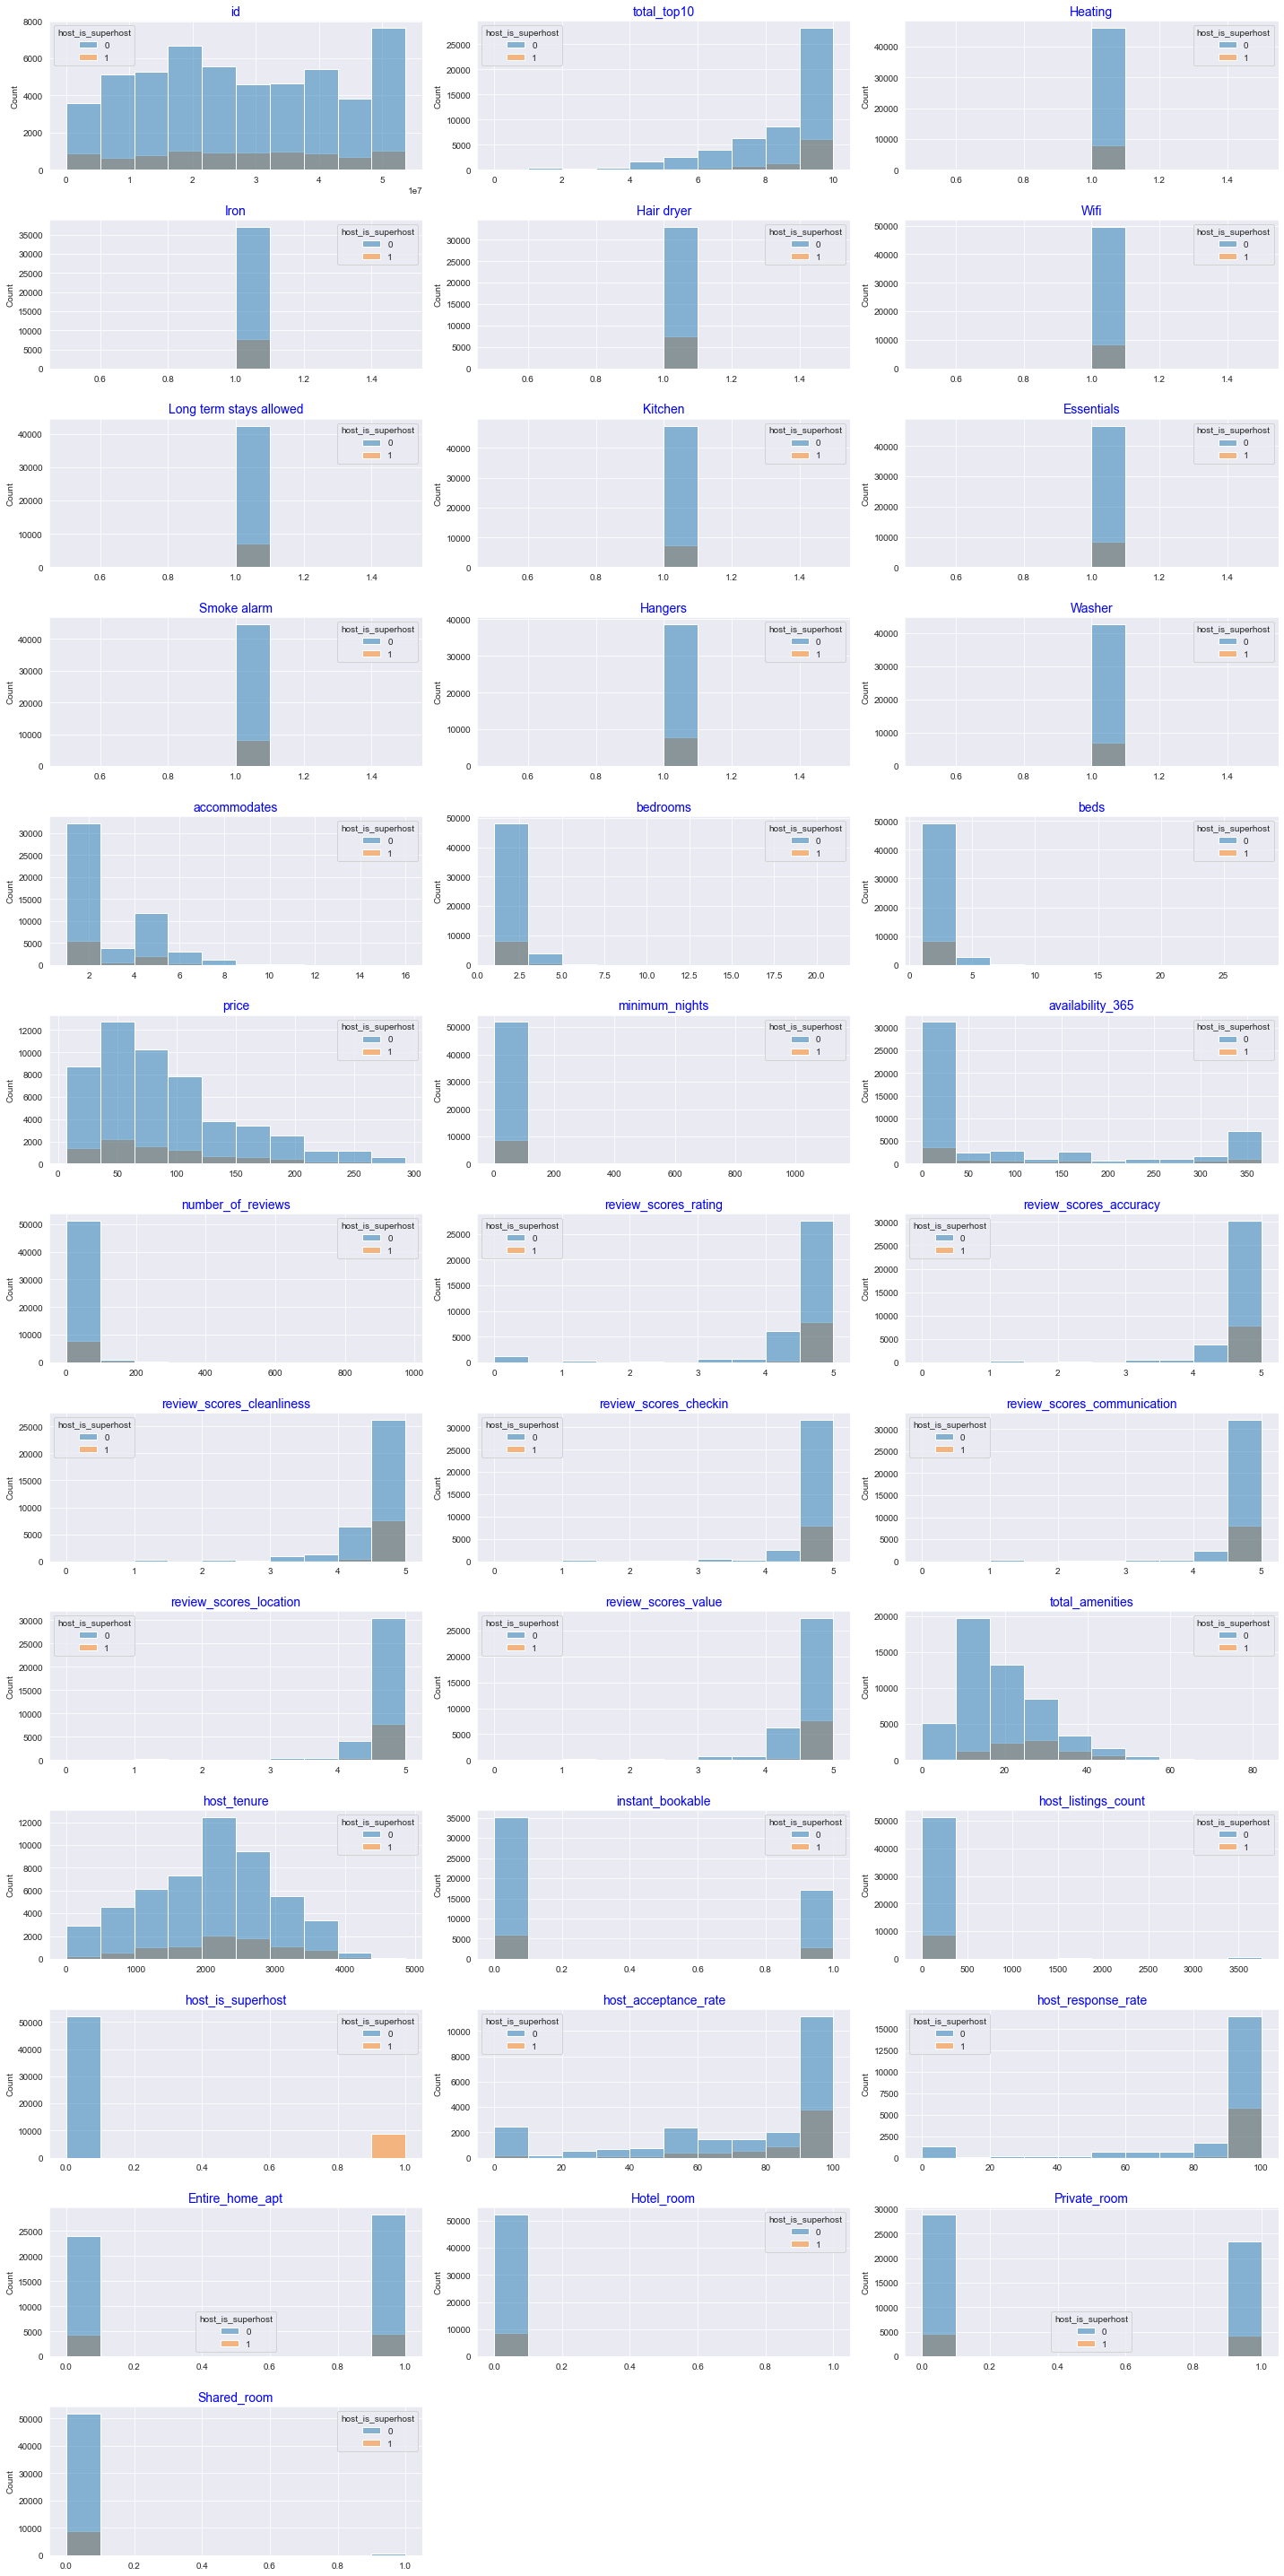

In [15]:
# select numeric columns to plot
col = list(final.select_dtypes(include=["float64", 'int64']).columns)


def n_rows(columns):
    '''
    This function return
    the number of rows for a subplot
    with 3 columns and a total of plot = len(columns to plot)
    '''
    if columns % 3 == 0:
        return columns // 3
    else:
        return (columns // 3) + 1


#     initializing plots
fig = plt.figure(figsize=(20, 40))

columns = 3
rows = n_rows(len(col))

# ploting
for i in range(1, len(col) + 1):
    fig.add_subplot(rows, columns, i)
    # Plots
    sns.histplot(data=final[final['price'] <= outlier],
                 x=col[i - 1],
                 bins=10,
                 hue='host_is_superhost')
    a = plt.gca()
    # a.lines[0].set_color('crimson')
    a.axes.set_xlabel('')
    plt.title(col[i - 1], size=14, color='blue')
    plt.tight_layout()

plt.show()

In [16]:
test_df = final.loc[:, :'number_of_reviews'].groupby(
    'neighbourhood_cleansed').median().sort_values(by='price', ascending=False)
test_df


,id,total_top10,Heating,Iron,Hair dryer,Wifi,Long term stays allowed,Kitchen,Essentials,Smoke alarm,Hangers,Washer,accommodates,bedrooms,beds,price,minimum_nights,availability_365,number_of_reviews
neighbourhood_cleansed,,,,,,,,,,,,,,,,,,,
City of London,38964320.0,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.000000,149.0,2.0,112.0,3.0
Kensington and Chelsea,31592705.0,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.758055,145.0,3.0,45.0,3.0
Westminster,33644007.5,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.758055,140.0,2.0,58.0,4.0
Camden,29583896.0,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.000000,100.0,2.0,14.0,4.0
Hammersmith and Fulham,24516095.0,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.000000,97.0,2.0,1.0,3.0
Richmond upon Thames,23779457.0,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.758055,92.0,2.0,10.0,4.0
Islington,23298894.0,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.000000,89.0,2.0,0.0,4.0
Wandsworth,25804607.0,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.000000,86.0,2.0,0.0,3.0
Southwark,25828817.0,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.000000,82.0,2.0,0.0,4.0


In [17]:
test_df.filter(like='City of London', axis=0)


,id,total_top10,Heating,Iron,Hair dryer,Wifi,Long term stays allowed,Kitchen,Essentials,Smoke alarm,Hangers,Washer,accommodates,bedrooms,beds,price,minimum_nights,availability_365,number_of_reviews
neighbourhood_cleansed,,,,,,,,,,,,,,,,,,,
City of London,38964320.0,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,149.0,2.0,112.0,3.0


In [18]:
def location_filter(location='City of London'):
    return test_df.filter(like=location, axis=0)

In [23]:
location_filter('Camden')

,id,total_top10,Heating,Iron,Hair dryer,Wifi,Long term stays allowed,Kitchen,Essentials,Smoke alarm,Hangers,Washer,accommodates,bedrooms,beds,price,minimum_nights,availability_365,number_of_reviews
neighbourhood_cleansed,,,,,,,,,,,,,,,,,,,
Camden,29583896.0,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,100.0,2.0,14.0,4.0


In [20]:
def draw_plot(df, column):
    '''
    Returns a scatter plot
    '''

    fig, ax1 = plt.subplots(figsize=(10,2))
    ax1 = sns.histplot(x=column, data=df, ax=ax1, bins=10,kde=True)
    fig.set_size_inches(10, 5)
    ax1.set_title(column.upper())

    return fig, ax1

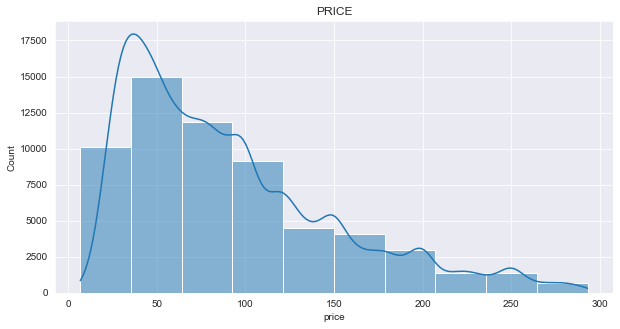

In [21]:
draw_plot(final[final['price'] <= outlier], 'price')
plt.show()